 usefull links
https://stats.stackexchange.com/questions/215733/svm-subgradient-descent-pegasos-algorithm 

In [1]:
pip install -U scikit-learn


  Using cached scikit_learn-1.2.0-cp39-cp39-win_amd64.whl (8.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip uninstall scikit-learn


# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.
  * decision function is simply the Euclidean distance (with a sign that designates from which side of the decision plane the point is located) from the decision plane to each sample. So, if you query for some point, you will get a positive number if the point is above the plain and negative if it is below it. The value will give you the distance which you can use for a scoring, for example, after you normalize it. If a point is very near to the decision plane it will have a lower score than a point that is farther. Also, if your point is located inside the margins of the model, you may want to treat the score as a probability for assigning the point to one class or another.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

1. *Implement a class *PegasosSVM* * which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).

In [33]:
# 1 #

# imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification

class PegasosSVM(BaseEstimator):
# hyper parameters 𝜆  and  𝑇 
    def __init__(self,T_iter=5000,Lambda=0.001):
        self.T_iter = T_iter  # max iter
        self.Lambda = Lambda  # the regularization param
    
# pad the samples with 1    
    def pad(self,X):
        return np.insert(X, 0,1, axis=1) # before colum = 0 insert  a column of ones.

    def fit(self,X,y, weights=None):
        self.weights = weights
# normalize and pad X:
        padded_X = self.pad(X)
# init weights to zero
        if type(self.weights) == type(None): self.weights = np.zeros(padded_X[0].shape)
# init S to len(y)
        num_S = len(y) 
# don't forget labels should be {-1,1} - change them if it is {0,1} or something else
        y = np.where(y <= 0, -1, 1)  
# update weight with gradient descent
        for i in range(self.T_iter):
            it = random.randint(0, num_S-1)
            step = 1/(self.Lambda*(i+1))
            decision = y[it] * self.weights.dot(padded_X[it])
            if decision < 1:
                self.weights = (1 - step*self.Lambda) * self.weights + step*y[it]*padded_X[it]
            else:
                self.weights = (1 - step*self.Lambda) * self.weights
            #weights = min(1, (1/math.sqrt(lam))/(np.linalg.norm(weights)))*weights

# decision_function returns a positive number if the point is above the plain and negative if it is below it. 
    def decision_function(self, X):
        return X @ self.weights
    
    def predict(self, X):
        X = self.pad(X)
        return np.sign(self.decision_function(X)) # y_pred
    
# used for cross validation    
    def score(self, X, y):
        y = np.where(y <= 0, -1, 1)
        pred = self.predict(X)
        return (pred == y).sum() / len(y)

In [34]:
import sklearn

2.  test your class on the breast cancer database load_breast_cancer, and compare your results to the Native Scikit-learn implementation LinearSVC

<class 'sklearn.utils._bunch.Bunch'>
<class 'pandas.core.frame.DataFrame'>
number of features: 30
number of samples: 569
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter err

C:\Users\Lior\AppData\Local\Temp\ipykernel_7960\3760734737.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (4,4))


[0 1]


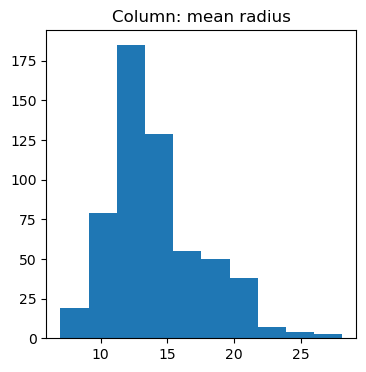

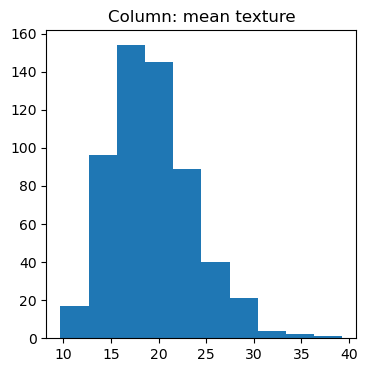

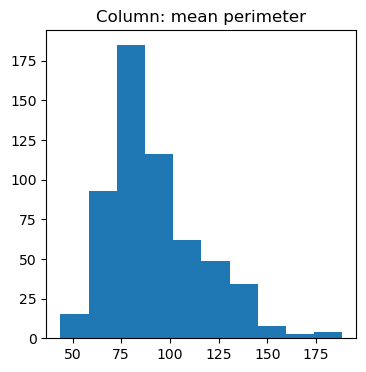

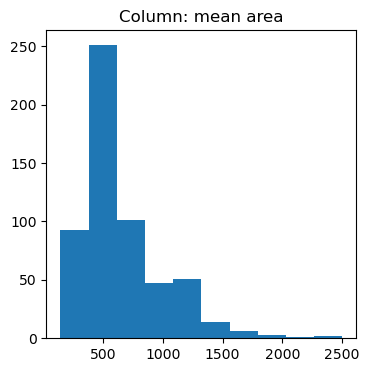

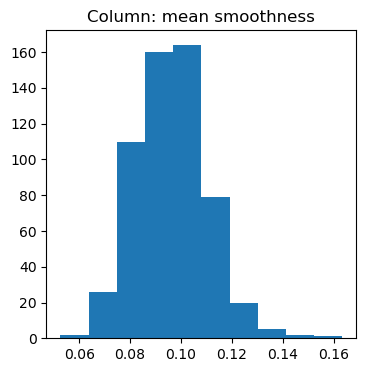

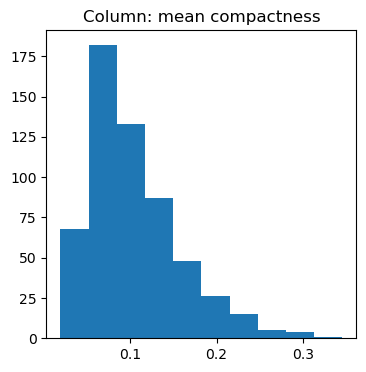

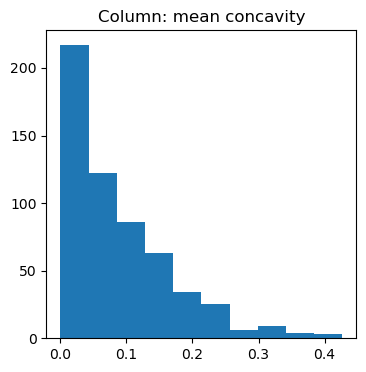

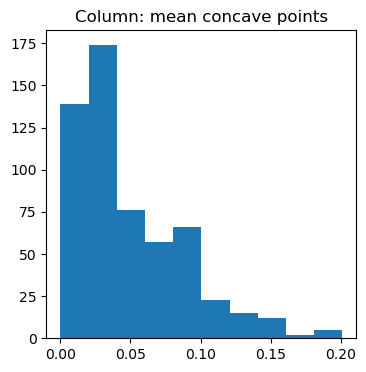

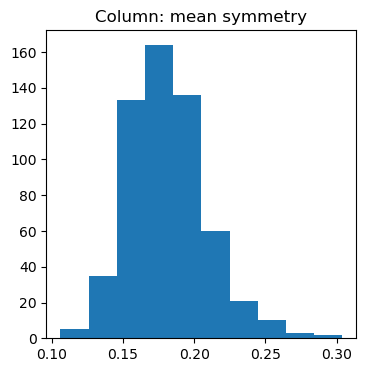

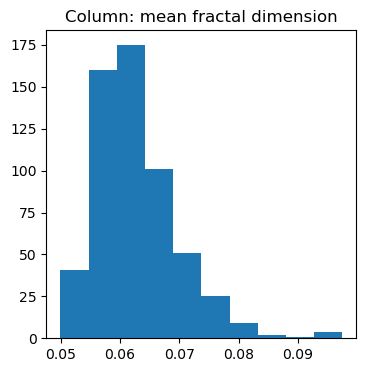

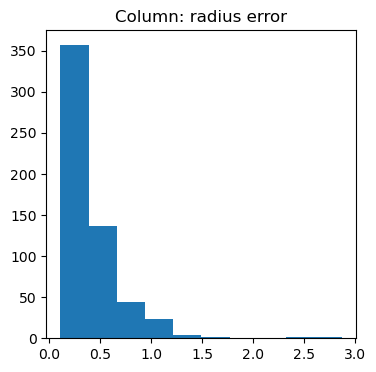

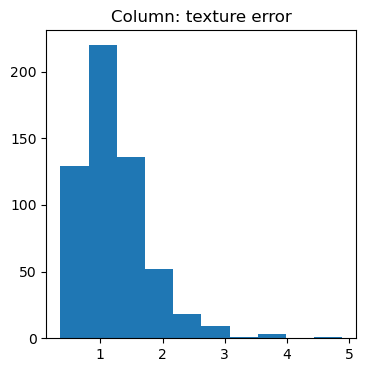

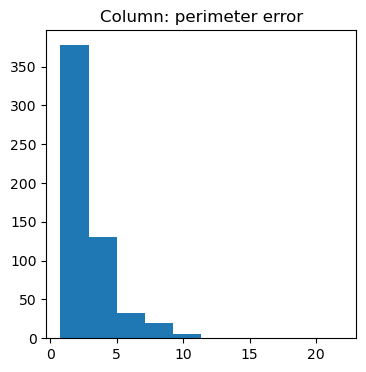

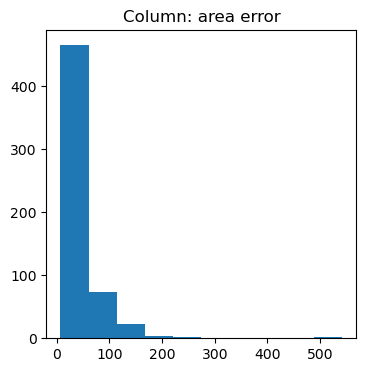

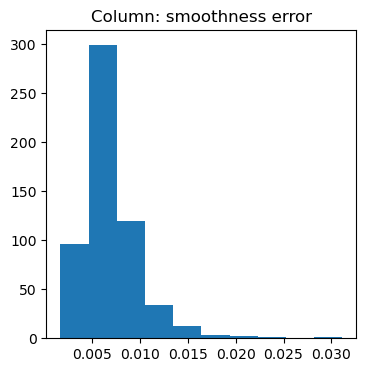

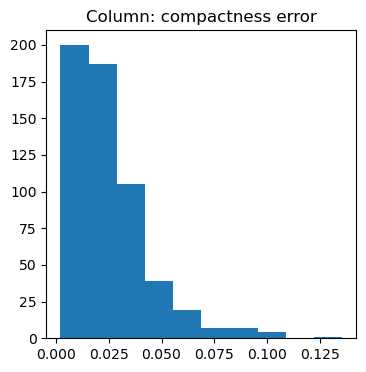

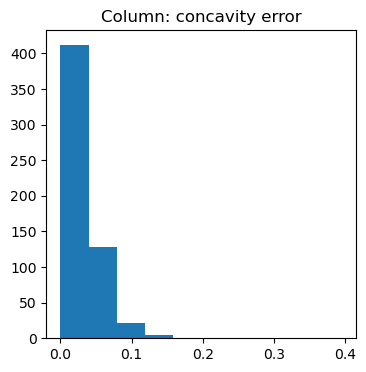

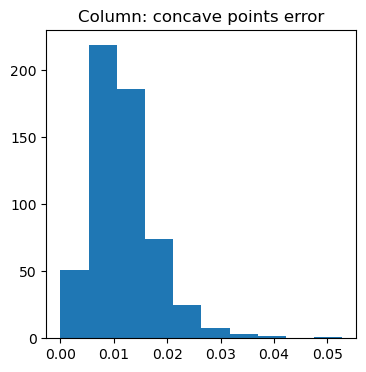

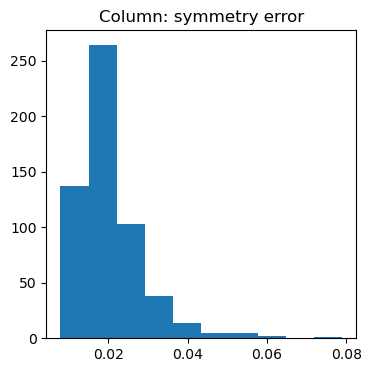

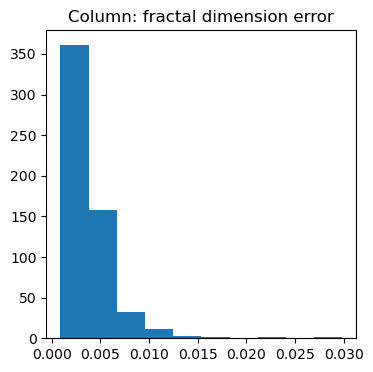

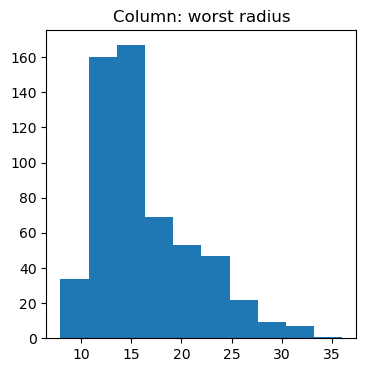

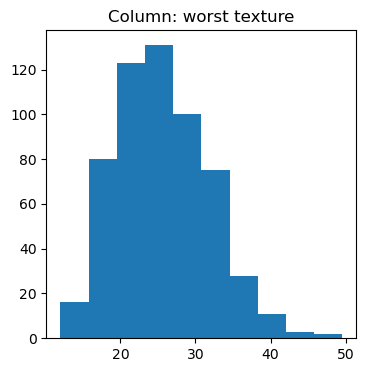

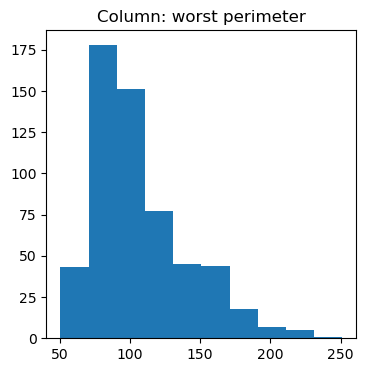

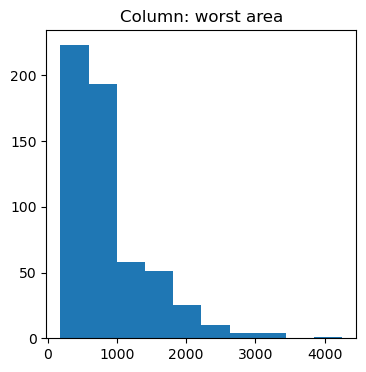

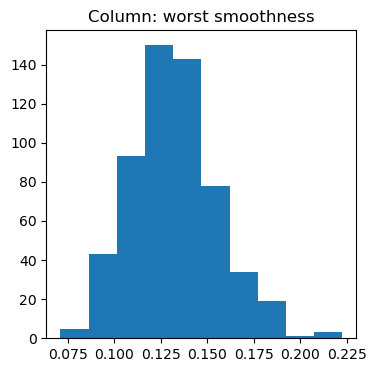

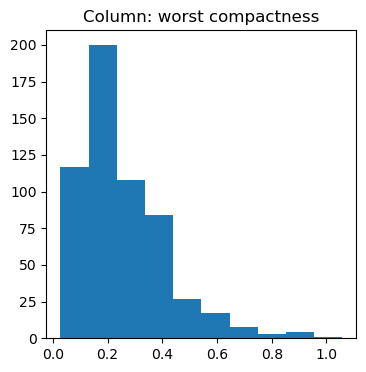

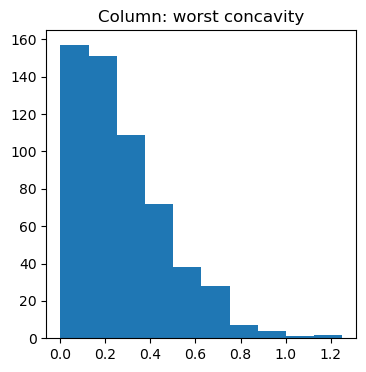

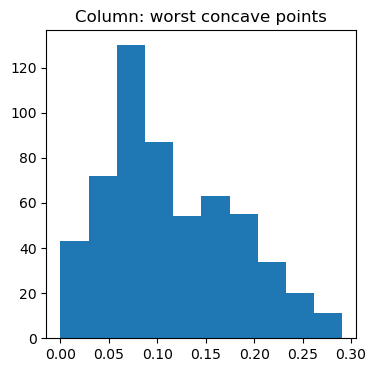

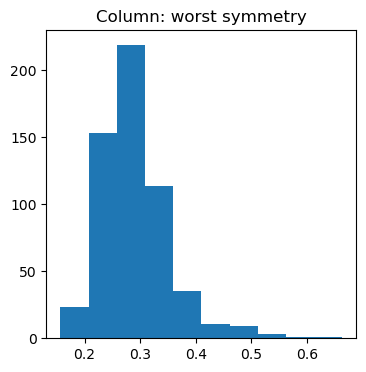

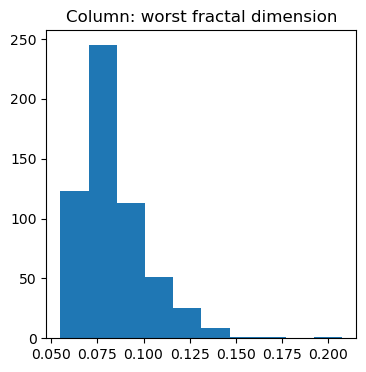

In [35]:
# Loading the data:
X,y = load_breast_cancer(return_X_y=True)

# EDA:
breast_cancer = load_breast_cancer()
print(type(breast_cancer))
breast_cancer_data = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
print(type(breast_cancer_data))
print("number of features:",breast_cancer_data.shape[1])
print("number of samples:",breast_cancer_data.shape[0])
breast_cancer_data.info()
breast_cancer_data.head()

# Visualization of Features
for col in breast_cancer_data.columns:
  plt.figure(figsize = (4,4))

  plt.hist(breast_cancer_data[col])
  plt.title(f'Column: {col}')
  #plt.show()

# show labels:
print(np.unique(y))
# we conclude that most features are noramly distributed, so we will use z-score standartization

In [36]:
# using svm on the data:
#X,y = load_breast_cancer(return_X_y=True)
PegasosSVM_pipe = Pipeline([('Scaler', StandardScaler()),('SVM', PegasosSVM())]) # standardize before applying SVM
PegasosSVM_scores = cross_val_score(PegasosSVM_pipe, X, y, cv=5)    
print("PegasosSVM mean score:",PegasosSVM_scores.mean())
SVC_pipe = Pipeline([('Scaler', StandardScaler()),('SVC', LinearSVC(max_iter=5000))])
SVC_scores = cross_val_score(SVC_pipe, X, y, cv=5)    
print("LinearSVC mean score:",SVC_scores.mean())

PegasosSVM mean score: 0.956016146561093
LinearSVC mean score: 0.9666511411271541


3. Analyze the effect of the hyper parameter  𝜆  on your training and test error.

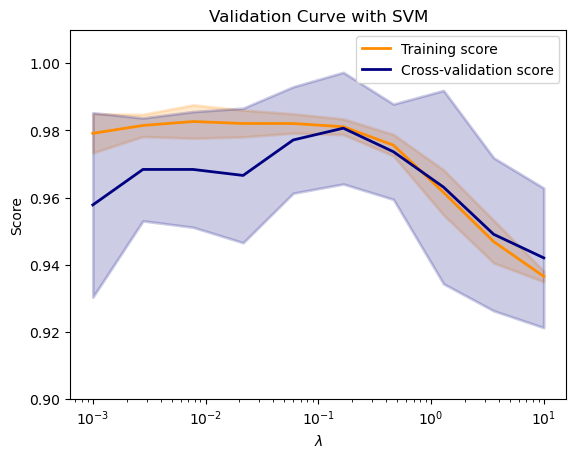

In [37]:
X,y = load_breast_cancer(return_X_y=True)

param_range = np.logspace(-3, 1, 10)
# using "validation_curve" - determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve(PegasosSVM_pipe, X, y, param_name = "SVM__Lambda",param_range=param_range ,cv=10,n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\lambda$")
plt.ylabel("Score")
plt.ylim(0.9, 1.01)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

4. Analyze the learning curve (performance as function of training size)

In [38]:
# Learning curves show the effect of adding more samples during th e training process. 
# The effect is depicted by checking the statistical performance of the model in terms of training score and testing score.

X,y = load_breast_cancer(return_X_y=True)
train_size_array = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
train_size_abs, train_scores, test_scores = learning_curve( PegasosSVM_pipe, X, y, train_sizes=train_size_array)
for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

91 samples were used to train the model
The average train accuracy is 0.99
The average test accuracy is 0.95
136 samples were used to train the model
The average train accuracy is 0.99
The average test accuracy is 0.92
182 samples were used to train the model
The average train accuracy is 0.98
The average test accuracy is 0.96
227 samples were used to train the model
The average train accuracy is 0.98
The average test accuracy is 0.96
273 samples were used to train the model
The average train accuracy is 0.98
The average test accuracy is 0.97
318 samples were used to train the model
The average train accuracy is 0.97
The average test accuracy is 0.96
364 samples were used to train the model
The average train accuracy is 0.98
The average test accuracy is 0.95
409 samples were used to train the model
The average train accuracy is 0.97
The average test accuracy is 0.96


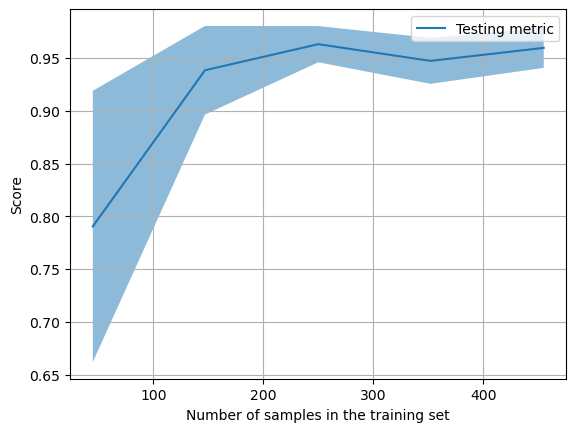

In [39]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(PegasosSVM_pipe, X, y)
plt.grid()
plt.show()

## 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this we created for you a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

TODO:
1. For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

2. Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

3. repeat the experiment but now set the `class_weight` to be `balanced`. 
The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

Explain what was the problem and how changing class weight solved it.


## Answer #

In [40]:
# a function make_data which generates a two dimensional dataset with n_samples=1000 where a fraction imbalance=0.1 is
# labeled 0 and the rest 1. The distribution of  𝑥  given  𝑦=0  or  𝑦=1  is gaussian with std 0.5 or 2, respectively and that
# the centers are at  𝑥1=0  and  𝑥2=−𝑑/2  and  𝑥2=𝑑/2 ,

def make_data(d, imbalance=0.1):
    n_samples=1000
    X = np.zeros((n_samples, 2))
    y = np.random.binomial(1, 1-imbalance, n_samples)
    size_0 = np.sum(y==0)
    size_1 = np.sum(y==1)
    X[y==0,0] = np.random.normal(loc=0, scale=0.5, size=size_0)
    X[y==1,0] = np.random.normal(loc=0, scale=2, size=size_1)
    X[y==0,1] = np.random.normal(loc=-d/2, scale=0.5, size=size_0)
    X[y==1,1] = np.random.normal(loc=d/2, scale=2, size=size_1)
    return X, y

For d=10 and d=2 plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

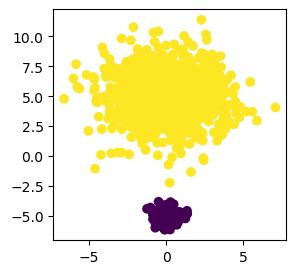

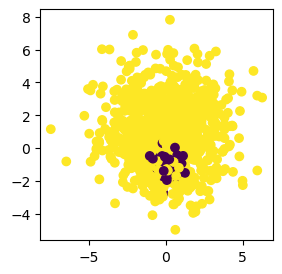

In [41]:
d = 10
X,y = make_data(d, imbalance=0.1)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0],X[:,1],c=y)
d = 2
X,y = make_data(d, imbalance=0.1)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0],X[:,1],c=y)

Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.
To plot the hyperplane, note that the fitted model has the coef_ and intercept_ properties. Add also the accuracy and the balanced_accuracy metrics to the plot title

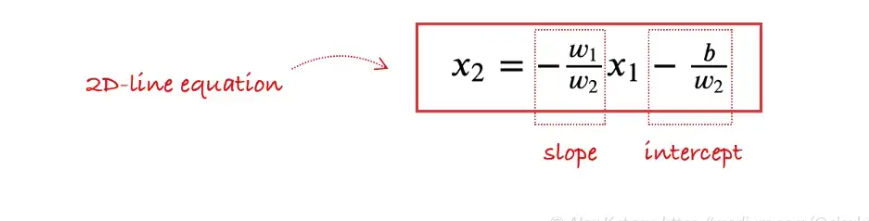

In [83]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

def plot_hyperplane(X,y):
    """ Plots the hyperplanes """
    #clf  = make_pipeline(StandardScaler(), LinearSVC())
    clf = LinearSVC()
    clf.fit(X, y)
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    balanced_accuracy = balanced_accuracy_score(y, y_pred)

    # Plotting the data
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title(f"d = {d} (acc={accuracy:.1%}, bal_acc={balanced_accuracy:.1%})")
    # Defining the hyperplane
    w = clf.coef_[0] 
    a = -w[0] / w[1] 
    xx = np.linspace(-10, 10)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # Defining the margins
    margin = 1 / np.sqrt(np.sum(clf.coef_**2))
    yy_down = yy - np.sqrt(1 + a**2) * margin
    yy_up = yy + np.sqrt(1 + a**2) * margin

    # Plotting the margins
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")

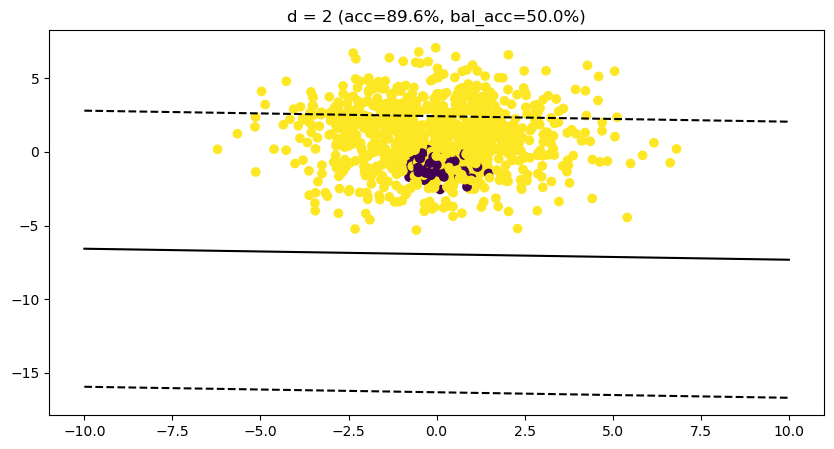

In [84]:
# For d=2
d = 2
X,y = make_data(d, imbalance=0.1)
plot_hyperplane(X,y)

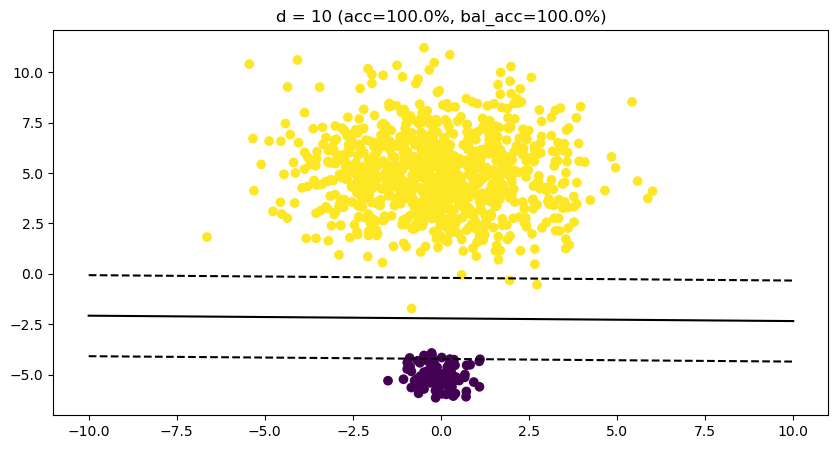

In [85]:
# For d=10
d = 10
X,y = make_data(d, imbalance=0.1)
plot_hyperplane(X,y)


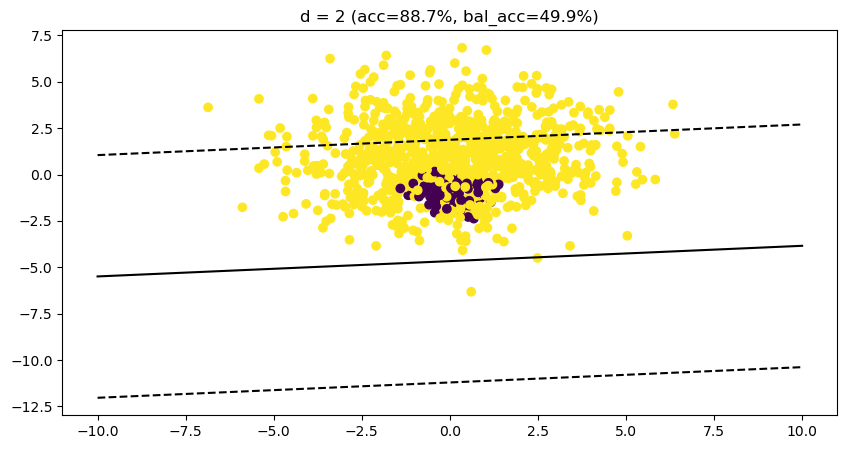

In [86]:
# For d=10
d = 2
X,y = make_data(d, imbalance=0.1)
plot_hyperplane(X,y)

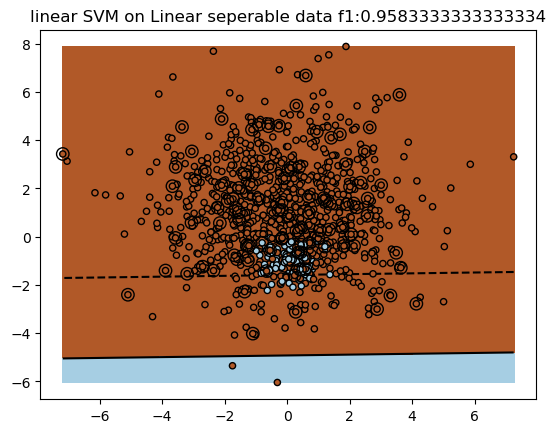

In [57]:
from sklearn.metrics import f1_score

def split_data(X,y):
    n_sample = len(X)
    X_train = X[: int(0.9 * n_sample)]
    y_train = y[: int(0.9 * n_sample)]
    X_test = X[int(0.9 * n_sample) :]
    y_test = y[int(0.9 * n_sample) :]
    return X_train, y_train, X_test, y_test

def plot_svm(clf,X,y,name):
    X_train, y_train, X_test, y_test = split_data(X,y)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    plt.scatter(
        X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor="k", s=20
    )

    # Circle out the test data
    plt.scatter(
        X_test[:, 0], X_test[:, 1], s=80, facecolors="none", zorder=10, edgecolor="k"
    )

    plt.axis("tight")
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(
        XX,
        YY,
        Z,
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
        levels=[-0.5, 0, 0.5],
    )
    f1 = f1_score(clf.predict(X_test),y_test)
    plt.title(name + f" f1:{f1}")
    return plt


#
d = 2
X,y = make_data(d, imbalance=0.1)
plt = plot_svm(LinearSVC(),X,y,f"linear SVM on Linear seperable data")
plt.show()

for d=10 the hyper plan goes through x_2 = -2.5
for d=2 there is no linear seperation between the data, we would need to use the "kernel trick"

3. repeat the experiment but now set the class_weight to be balanced. The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

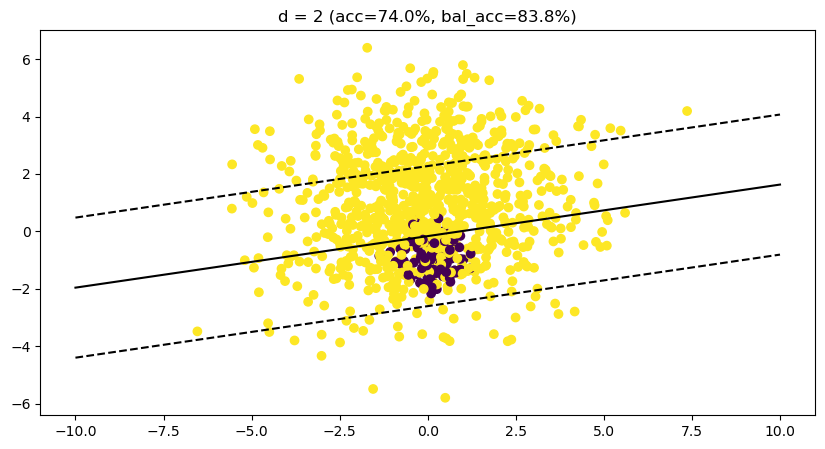

In [89]:

def plot_hyperplane(X,y):
    """ Plots the hyperplanes """
    #clf  = make_pipeline(StandardScaler(), LinearSVC())
    clf = LinearSVC(class_weight="balanced")
    clf.fit(X, y)
    y_pred = clf.predict(X)
    accuracy = accuracy_score(y, y_pred)
    balanced_accuracy = balanced_accuracy_score(y, y_pred)

    # Plotting the data
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title(f"d = {d} (acc={accuracy:.1%}, bal_acc={balanced_accuracy:.1%})")
    # Defining the hyperplane
    w = clf.coef_[0] 
    a = -w[0] / w[1] 
    xx = np.linspace(-10, 10)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # Defining the margins
    margin = 1 / np.sqrt(np.sum(clf.coef_**2))
    yy_down = yy - np.sqrt(1 + a**2) * margin
    yy_up = yy + np.sqrt(1 + a**2) * margin

    # Plotting the margins
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")

# For d=10
d = 2
X,y = make_data(d, imbalance=0.1)
plot_hyperplane(X,y)

## 3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.

Use the cancer dataset for this question


## Answer #

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4) 

# Trainig the naive, default model
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', LinearSVC())
])
model.fit(X_train, y_train)

# Defualt param model scores:
print("Default LinearSVC model (C=1, loss=squared_hinge, multi_class=ovr):")
print(f"    Training accuracy: {accuracy_score(y_train, model.predict(X_train)):.2%}")
print(f"    Test accuracy: {accuracy_score(y_test, model.predict(X_test)):.2%}")

# Gridsearch
parameters = {
    'svc__C':np.logspace(-3,3,10), 
    'svc__multi_class':['ovr', 'crammer_singer'],
    'svc__loss':['hinge', 'squared_hinge']
}
grid = GridSearchCV(model, cv=3, param_grid=parameters)
grid.fit(X_train, y_train)
print(f"Best tuned LinearSVC model (C={grid.best_params_['svc__C']:.4f}, loss={grid.best_params_['svc__loss']}, multi_class={grid.best_params_['svc__multi_class']}):")
print(f"    Training accuracy: {accuracy_score(y_train, grid.predict(X_train)):.2%}")
print(f"    Test accuracy: {accuracy_score(y_test, grid.predict(X_test)):.2%}")

Default LinearSVC model (C=1, loss=squared_hinge, multi_class=ovr):
    Training accuracy: 98.83%
    Test accuracy: 97.37%


C:\Users\Lior\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Lior\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Best tuned LinearSVC model (C=0.0215, loss=hinge, multi_class=ovr):
    Training accuracy: 97.65%
    Test accuracy: 98.25%


## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [102]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

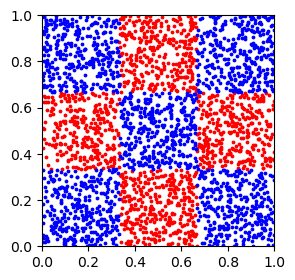

In [103]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

Use the checkboard function below to generate your training set (1000 or 2000 samples) and a testing set (as much as you like).

In [108]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1000) 
X_train.shape

(2000, 2)

Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.

In [124]:
# Trainig the naive, default model
def_model = Pipeline([('scaler', StandardScaler()), ('svc', LinearSVC())])
poly_model = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel="poly"))])
Gau_model = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel="rbf"))])

# Defualt param model scores:
def_model.fit(X_train, y_train)
print("Default LinearSVC model ():")
print(f"    Training accuracy: {accuracy_score(y_train, def_model.predict(X_train)):.2%}")
print(f"    Test accuracy: {accuracy_score(y_test, def_model.predict(X_test)):.2%}")
# Poly kernem model scores:
poly_model.fit(X_train, y_train)
print("Poly LinearSVC model ():")
print(f"    Training accuracy: {accuracy_score(y_train, poly_model.predict(X_train)):.2%}")
print(f"    Test accuracy: {accuracy_score(y_test, poly_model.predict(X_test)):.2%}")
# Gaussian kernem model scores:
Gau_model.fit(X_train, y_train)
print("Gaussian LinearSVC model ():")
print(f"    Training accuracy: {accuracy_score(y_train, Gau_model.predict(X_train)):.2%}")
print(f"    Test accuracy: {accuracy_score(y_test, Gau_model.predict(X_test)):.2%}")

Default LinearSVC model ():
    Training accuracy: 55.40%
    Test accuracy: 55.80%
Poly LinearSVC model ():
    Training accuracy: 55.40%
    Test accuracy: 55.80%
Gaussian LinearSVC model ():
    Training accuracy: 94.60%
    Test accuracy: 93.10%


## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

